In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/Users/nicole/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load in data

In [2]:
file_path_trainC = "widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.csv"
train_cat = pd.read_csv(file_path_trainC)

file_path_trainFCM = "widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
train_FCM = pd.read_csv(file_path_trainFCM)

file_path_trainQ = "widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.csv"
train_Quant = pd.read_csv(file_path_trainQ)

file_path_trainS = "widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.csv"
train_Solutions = pd.read_csv(file_path_trainS)
train_Solutions.drop(columns = ['Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [3]:
file_path_testC = "widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx"
test_cat = pd.read_excel(file_path_testC)

file_path_testFCM = "widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_FCM = pd.read_csv(file_path_testFCM)

file_path_testQ = "widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx"
test_Quant = pd.read_excel(file_path_testQ)

In [4]:
file_path_trainS = "widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.csv"
train_Solutions = pd.read_csv(file_path_trainS)

## Combine train and test categorical data sets in order to get summative one hot encoding

In [5]:
train_shape = train_cat.shape

for col in train_cat.select_dtypes(include='number').columns:
    train_cat[col] = train_cat[col].astype('Int64')
    train_cat[col] = train_cat[col].astype('category')
    
for col in test_cat.select_dtypes(include='number').columns:
    test_cat[col] = test_cat[col].astype('Int64')
    test_cat[col] = test_cat[col].astype('category')
    
cat_train_test = pd.concat([train_cat, test_cat], axis = 0).reset_index(drop = True)
columns_to_encode = cat_train_test.columns[1:].tolist()
cat_train_test_final = cat_train_test.drop(columns = columns_to_encode)

for col in cat_train_test.columns[1:]:
    encoded = pd.get_dummies(cat_train_test[col], prefix = col)
    cat_train_test_final = pd.concat([cat_train_test_final, encoded], axis = 1)

cat_train_test_final.head()

,participant_id,Basic_Demos_Enroll_Year_2015,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Enroll_Year_2021,Basic_Demos_Enroll_Year_2022,Basic_Demos_Enroll_Year_2023,...,Barratt_Barratt_P2_Occ_0,Barratt_Barratt_P2_Occ_5,Barratt_Barratt_P2_Occ_10,Barratt_Barratt_P2_Occ_15,Barratt_Barratt_P2_Occ_20,Barratt_Barratt_P2_Occ_25,Barratt_Barratt_P2_Occ_30,Barratt_Barratt_P2_Occ_35,Barratt_Barratt_P2_Occ_40,Barratt_Barratt_P2_Occ_45
0,UmrK0vMLopoR,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,CPaeQkhcjg7d,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Nb4EetVPm3gs,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,p4vPhVu91o4b,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,M09PXs7arQ5E,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Split back into training and testing sets and combine with quantitative data

In [6]:
cat_train_final = cat_train_test_final.iloc[0:train_shape[0]]
cat_test_final = cat_train_test_final.iloc[train_shape[0]:]

## Perform PCA on FCM Data

In [7]:
train_FCM[train_FCM.columns[1:]]

,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,0throw_10thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,0.093473,0.146902,0.067893,0.015141,0.070221,0.063997,0.055382,-0.035335,0.068583,0.029271,...,0.003404,-0.010359,-0.050968,-0.014365,0.128066,0.112646,-0.058980,0.028228,0.133582,0.143372
1,0.029580,0.179323,0.112933,0.038291,0.104899,0.064250,0.008488,0.077505,-0.004750,-0.035073,...,-0.008409,-0.008479,0.020891,0.017754,0.094040,0.035141,0.032537,0.075007,0.115350,0.138200
2,-0.051580,0.139734,0.068295,0.046991,0.111085,0.026978,0.151377,0.021198,0.083721,-0.014275,...,0.053245,-0.028003,0.028773,0.024556,0.166343,0.058925,0.035485,0.063661,0.042862,0.162162
3,0.016273,0.204702,0.115980,0.043103,0.056431,0.057615,0.055773,0.075030,0.001033,-0.064031,...,-0.023918,-0.005356,0.018607,0.016193,0.072955,0.130135,0.056120,0.084784,0.114148,0.190584
4,0.065771,0.098714,0.097604,0.112988,0.071139,0.085607,0.019392,-0.036403,-0.020375,0.005426,...,0.066439,-0.076680,-0.047530,-0.031443,0.221213,0.007343,0.005763,0.083820,0.079582,0.067269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,0.022932,0.024830,-0.006514,0.021070,0.093365,0.083369,0.010991,0.035838,0.023909,-0.010682,...,0.060060,-0.003911,-0.016413,0.089110,0.118587,-0.060868,0.124443,0.028510,0.113064,0.103809
1209,0.047078,0.135955,0.144366,0.054938,0.065760,0.113550,0.032621,0.025349,0.011848,-0.015673,...,0.021318,0.020141,-0.020920,0.030450,0.190241,0.026461,-0.011593,0.139483,-0.064480,0.070354
1210,0.094541,0.145280,0.061964,0.030562,0.078278,0.105857,0.043984,0.039145,0.032024,-0.018199,...,-0.052990,-0.002118,-0.038452,0.066608,0.143446,0.051221,0.127495,0.106242,-0.036065,0.151341
1211,-0.001533,0.128562,0.045000,-0.008742,0.003673,0.086494,0.090101,-0.037449,-0.026334,0.050006,...,0.024479,-0.036995,-0.061617,-0.001699,0.106568,0.023427,-0.003520,0.174972,0.041198,0.152029


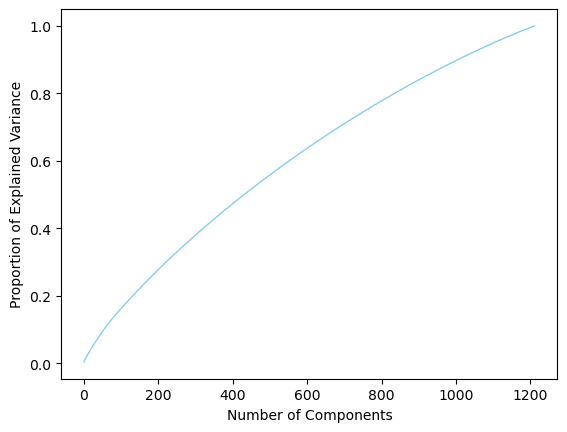

In [14]:
from sklearn.decomposition import PCA

# standardize data
scaling = StandardScaler()
scaling.fit(train_FCM[train_FCM.columns[1:]])
scaled_fcm_train = scaling.transform(train_FCM[train_FCM.columns[1:]])

# fit and transform
pca = PCA()
pca.fit_transform(scaled_fcm_train)

# variance ratios
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
plt.plot(cumulative_variance, lw = 1, color = 'skyblue')
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Explained Variance')
plt.savefig('pca.pdf')
plt.show()

# Conclusion from PCA on applicable data

This was not helpful. Would normally use this method to see at what point the number of components started to really explain the variance, but since its a smooth curve, we can't really say there's a specific point at which a few components explain most of the variance, allowing us to reduce the number of features.

## Put the dataframes back together

In [9]:
train_cat_FCM = pd.merge(cat_train_final, train_FCM, on = 'participant_id')
train_df = pd.merge(train_cat_FCM, train_Quant, on = 'participant_id')

# ensure it looks accurate
print(train_df.shape)
train_df.head()

(1213, 19988)


,participant_id,Basic_Demos_Enroll_Year_2015,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Enroll_Year_2021,Basic_Demos_Enroll_Year_2022,Basic_Demos_Enroll_Year_2023,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,UmrK0vMLopoR,0,1,0,0,0,0,0,0,0,...,0,6,1,5,0,5,1,0,10,NaN
1,CPaeQkhcjg7d,0,0,0,0,1,0,0,0,0,...,0,18,6,8,7,8,10,4,5,NaN
2,Nb4EetVPm3gs,0,1,0,0,0,0,0,0,0,...,1,14,2,8,5,7,6,4,9,8.239904
3,p4vPhVu91o4b,0,0,0,1,0,0,0,0,0,...,6,24,4,16,9,10,8,4,6,NaN
4,M09PXs7arQ5E,0,0,0,0,1,0,0,0,0,...,1,18,4,11,4,10,7,3,9,8.940679


In [10]:
test_cat_FCM = pd.merge(cat_test_final, test_FCM, on = 'participant_id')
test_df = pd.merge(test_cat_FCM, test_Quant, on = 'participant_id')

# ensure it looks accurate
print(test_df.shape)
test_df.head()

(304, 19988)


,participant_id,Basic_Demos_Enroll_Year_2015,Basic_Demos_Enroll_Year_2016,Basic_Demos_Enroll_Year_2017,Basic_Demos_Enroll_Year_2018,Basic_Demos_Enroll_Year_2019,Basic_Demos_Enroll_Year_2020,Basic_Demos_Enroll_Year_2021,Basic_Demos_Enroll_Year_2022,Basic_Demos_Enroll_Year_2023,...,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
0,Cfwaf5FX7jWK,0,0,0,0,0,0,0,1,0,...,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
1,vhGrzmvA3Hjq,0,0,0,0,0,0,0,0,1,...,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093
2,ULliyEXjy4OV,0,0,0,0,0,0,0,1,0,...,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0,9.0,7.770933
3,LZfeAb1xMtql,0,0,0,0,0,0,0,1,0,...,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0,6.0,9.304814
4,EnFOUv0YK1RG,0,0,0,0,0,0,0,1,0,...,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0,10.0,8.261350


### Fill NaN values and missings

In [11]:
print(train_df.isna().sum())

train_df.fillna({'MRI_Track_Age_at_Scan':train_df['MRI_Track_Age_at_Scan'].mean()}, inplace = True)

print(train_df.isna().sum().sum()) # should now be zero

participant_id                    0
Basic_Demos_Enroll_Year_2015      0
Basic_Demos_Enroll_Year_2016      0
Basic_Demos_Enroll_Year_2017      0
Basic_Demos_Enroll_Year_2018      0
                               ... 
SDQ_SDQ_Hyperactivity             0
SDQ_SDQ_Internalizing             0
SDQ_SDQ_Peer_Problems             0
SDQ_SDQ_Prosocial                 0
MRI_Track_Age_at_Scan           360
Length: 19988, dtype: int64
0


## Training time

In [12]:
X_train = train_df.drop(columns = ['participant_id'])
Y_train = train_Solutions.drop(columns = ['participant_id', 'Unnamed: 3', 'Unnamed: 4'])

### Create decision tree classifier

In [13]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Initialize the base classifier
xgb_classifier = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5)

# Wrap with MultiOutputClassifier for multi-target classification
multioutput_classifier = MultiOutputClassifier(xgb_classifier)

# Train the model
multioutput_classifier.fit(X_train, Y_train)

KeyboardInterrupt: 

### Predict with PCA version of FCM data

In [ ]:
participant_id = test_df['participant_id']

X_test = test_df.drop(columns = ['participant_id'])

y_pred = multioutput_classifier.predict(X_test)

In [ ]:
# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(y_pred, columns=['Predicted_Gender', 'Predicted_ADHD'])

# Combine participant IDs with predictions
result_df = pd.concat([participant_id.reset_index(drop=True), predictions_df], axis=1)

# Print or save the DataFrame
print(result_df)

### Evaluate

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

Define a custom accuracy metric for multi-output classification, where each target variable (column) needs a separate accuracy calculation.

This function will:


*   Converts y_true and y_pred into NumPy arrays to enable indexing like `[:, i].`
*   Iterates over each column (i.e., target variable) in y_true and y_pred.
* Computes the accuracy score for each target variable using accuracy_score.
* Returns the average accuracy across all target variables.

In [ ]:
def multi_output_accuracy(y_true, y_pred):
    # Ensure y_true and y_pred are NumPy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Compute accuracy for each target variable and return the mean
    return np.mean([accuracy_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

Then we will wrap the multi_output_accuracy function into a scorer object that can be used with scikit-learn's evaluation tools (e.g., cross_val_score). This will automatically create the `y_true` and `y_pred` being used in our function above.

In [ ]:
# Create a scorer using scikit-learn's make_scorer
multi_output_scorer = make_scorer(multi_output_accuracy)

In [ ]:
# Perform cross-validation on the training data
cv_scores = cross_val_score(multioutput_classifier, X_train, Y_train, cv = 5, scoring = multi_output_scorer)

# Output the cross-validation results
print("Cross-validation scores for each fold:", cv_scores)
print("Mean CV score:", np.mean(cv_scores))

# CV w/ no logistic regression
# Cross-validation scores for each fold: [0.82304527 0.78600823 0.69341564 0.64669421 0.33471074]
# Mean CV score: 0.6567748188960311